In [1]:
from utils import CNNBackbone, LSTMBackbone, ASTBackbone, get_device, SpectrogramDataset, CLASS_MAPPING, torch_train_val_split, Regressor, train, set_seed, plot_train_val_losses, test_model, get_regression_report, free_gpu_memory
import torch.optim as optim
import os
import torch

# DATA_PATH = "/home/alex/Downloads/archive(1)/data/"
DATA_PATH = os.path.join(os.getcwd(), "data/")
model_weights_path = os.path.join(os.getcwd(), "model_weights/")
assets_path = os.path.join(os.getcwd(), "assets/")

mel_specs_path = DATA_PATH + "fma_genre_spectrograms/"
multitask_path = DATA_PATH + "multitask_dataset/"
beat_mel_specs_path = DATA_PATH + "fma_genre_spectrograms_beat/"
os.makedirs(model_weights_path, exist_ok=True)
os.makedirs(assets_path, exist_ok=True)

EPOCHS = 100
LR = 1e-4
BATCH_SIZE = 8
VAL_SIZE = 0.2
RANDOM_SEED = 42
RNN_HIDDEN_SIZE = 64
NUM_CATEGORIES = 1
cnn_in_channels = 1
cnn_filters = [32, 64, 128, 256]
cnn_out_feature_size = 256
DEVICE = get_device()

#### Prepare Data

Regression = 1 for Valence Labels

Regression = 2 for Valence Energy

Regression = 3 for Valence Danceability

In [2]:
valence_data = SpectrogramDataset(multitask_path, class_mapping=CLASS_MAPPING, train=True, regression=1)
energy_data = SpectrogramDataset(multitask_path, class_mapping=CLASS_MAPPING, train=True, regression=2)
danceability_data = SpectrogramDataset(multitask_path, class_mapping=CLASS_MAPPING, train=True, regression=3)

valence_train_dl, valence_val_dl = torch_train_val_split(dataset=valence_data, batch_eval=BATCH_SIZE, batch_train=BATCH_SIZE, val_size=VAL_SIZE, shuffle=True)
energy_train_dl, energy_val_dl = torch_train_val_split(dataset=energy_data, batch_eval=BATCH_SIZE, batch_train=BATCH_SIZE, val_size=VAL_SIZE, shuffle=True)
danceability_train_dl, danceability_val_dl = torch_train_val_split(dataset=danceability_data, batch_eval=BATCH_SIZE, batch_train=BATCH_SIZE, val_size=VAL_SIZE, shuffle=True)

#### Overfit LSTM model on one batch to make sure everything works

In [3]:
set_seed(RANDOM_SEED)
backbone = LSTMBackbone(danceability_data.feat_dim, rnn_size=64, num_layers=2, bidirectional=False)
set_seed(RANDOM_SEED)
model = Regressor(backbone).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

train(model, danceability_train_dl, danceability_val_dl, optimizer, EPOCHS, device=DEVICE, overfit_batch=True, regression_flag=True)

Training in overfitting mode...
Epoch 1, Loss at training set: 0.3797714412212372
Epoch 20, Loss at training set: 0.13163816928863525
Epoch 40, Loss at training set: 0.03149328753352165
Epoch 60, Loss at training set: 0.010561058297753334
Epoch 80, Loss at training set: 0.010487025603652
Epoch 100, Loss at training set: 0.008272742852568626


#### Overfit CNN model on one batch to make sure everything works

In [4]:
set_seed(RANDOM_SEED)
backbone = CNNBackbone(danceability_data[0][0].shape, cnn_in_channels, cnn_filters, cnn_out_feature_size)
set_seed(RANDOM_SEED)
model = Regressor(backbone).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

train(model, danceability_train_dl, danceability_val_dl, optimizer, EPOCHS, device=DEVICE, overfit_batch=True, regression_flag=True)

Training in overfitting mode...
Epoch 1, Loss at training set: 0.07652541995048523
Epoch 20, Loss at training set: 261.4669494628906
Epoch 40, Loss at training set: 26.798847198486328
Epoch 60, Loss at training set: 4.126636505126953
Epoch 80, Loss at training set: 0.10573296248912811
Epoch 100, Loss at training set: 0.06820379197597504


#### Overfit AST model on one batch to make sure everything works

In [25]:
set_seed(RANDOM_SEED)
backbone = ASTBackbone(
    fstride=10,                     
    tstride=10,                   
    input_fdim=danceability_data[0][0].shape[1],      
    input_tdim=danceability_data[0][0].shape[0],     
    imagenet_pretrain=True,      
    model_size='tiny224',          
    feature_size=1    
)
set_seed(RANDOM_SEED)
model = Regressor(backbone).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

train(model, danceability_train_dl, danceability_val_dl, optimizer, EPOCHS, device=DEVICE, overfit_batch=True, regression_flag=True)

Training in overfitting mode...
Epoch 1, Loss at training set: 0.036440327763557434
Epoch 20, Loss at training set: 0.006927387788891792
Epoch 40, Loss at training set: 0.0020198298152536154
Epoch 60, Loss at training set: 0.00036697532050311565
Epoch 80, Loss at training set: 0.00021007384930271655
Epoch 100, Loss at training set: 0.00010530994040891528


In [19]:

def train_modular_regressor(model_name, backbone, train_loader, val_loader, device, epochs, lr):
    print(f"Free GPU Memory: {free_gpu_memory():.2f}%")
    set_seed(RANDOM_SEED)
    model = Regressor(backbone).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, val_losses = train(
    model=model, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=epochs,
    device=device, overfit_batch=False, regression_flag=True, save_path=f"model_weights/{model_name}_best.pth"
    )
    
    plot_train_val_losses(train_losses, val_losses, save_title=f"assets/{model_name}_train_val_losses.png")
    return model

#### Train and eval LSTM Regressor on Valence Dataset

Training started for model model_weights/lstm_valence_best...
Epoch 1/100
	Average Training Loss: 0.0830770696027089 (9.43s)
	Average Validation Loss: 0.06690560154882925(1.18s)
Epoch 2/100
	Average Training Loss: 0.0670763194824742 (9.44s)
	Average Validation Loss: 0.06606363937524813(1.12s)
Epoch 3/100
	Average Training Loss: 0.06396742890366411 (9.38s)
	Average Validation Loss: 0.06549447355791926(1.16s)
Epoch 4/100
	Average Training Loss: 0.0649164548160228 (9.47s)
	Average Validation Loss: 0.06574611651844212(1.19s)
Epoch 5/100
	Average Training Loss: 0.06400418035949754 (9.26s)
	Average Validation Loss: 0.06541703282190221(1.14s)
Epoch 6/100
	Average Training Loss: 0.06462966433141083 (9.68s)
	Average Validation Loss: 0.06799788332344699(1.20s)
Epoch 7/100
	Average Training Loss: 0.06337110219374958 (9.65s)
	Average Validation Loss: 0.06705329407538686(1.18s)
Epoch 8/100
	Average Training Loss: 0.0632477146202484 (9.55s)
	Average Validation Loss: 0.06670811532863549(1.09s)
Epoch 

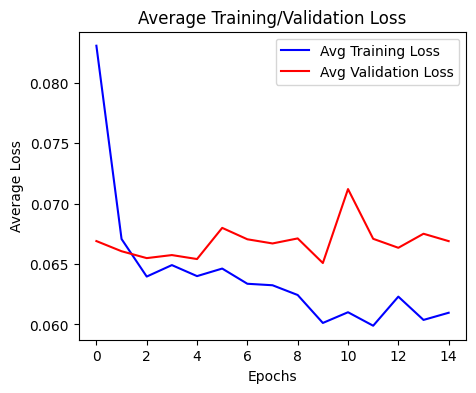

LSTM Regressor on Valence Dataset
	Spearman Correlation: 0.1233
	MSE: 0.0669
	MAE: 0.2203
	RMSE: 0.2587


In [6]:
set_seed(RANDOM_SEED)
backbone = LSTMBackbone(valence_data.feat_dim, rnn_size=64, num_layers=2, bidirectional=True)

model = train_modular_regressor(
    model_name="lstm_valence",
    backbone=backbone,
    train_loader=valence_train_dl,
    val_loader=valence_val_dl,
    device=DEVICE,
    epochs=EPOCHS,
    lr=LR
)

y_true, y_pred, spear_corrs, pear_corrs = test_model(model, valence_val_dl, DEVICE, regression_flag=True)

print("LSTM Regressor on Valence Dataset")
get_regression_report(y_pred, y_true, spear_corrs, pear_corrs)

#### Train and Evaluate CNN Regressor on Valence Dataset

Training started for model model_weights/cnn_valence_best...
Epoch 1/100
	Average Training Loss: 325.4361008980633 (8.44s)
	Average Validation Loss: 2.027470967599324(0.58s)
Epoch 2/100
	Average Training Loss: 1.8150118742368917 (8.12s)
	Average Validation Loss: 1.4072203524410725(0.57s)
Epoch 3/100
	Average Training Loss: 0.8654120333690559 (8.21s)
	Average Validation Loss: 0.7044864642832961(0.58s)
Epoch 4/100
	Average Training Loss: 0.6343920885923162 (8.17s)
	Average Validation Loss: 0.45640920262251583(0.63s)
Epoch 5/100
	Average Training Loss: 0.49299552192730184 (8.56s)
	Average Validation Loss: 0.2737086173146963(0.73s)
Epoch 6/100
	Average Training Loss: 0.3702281058098363 (8.34s)
	Average Validation Loss: 0.36218034316386494(0.58s)
Epoch 7/100
	Average Training Loss: 0.3769228488734338 (8.27s)
	Average Validation Loss: 0.22162662353366613(0.58s)
Epoch 8/100
	Average Training Loss: 0.32397717303406875 (8.14s)
	Average Validation Loss: 0.27426816057413816(0.58s)
Epoch 9/100
	Av

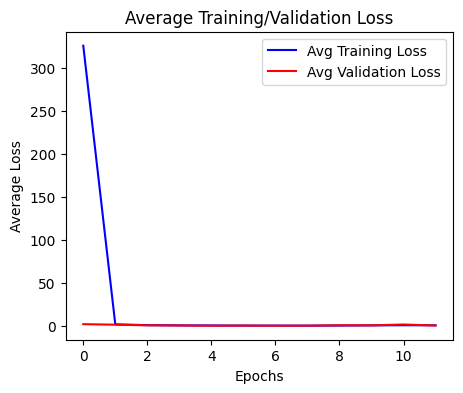

CNN Regressor on Valence Dataset
	Spearman Correlation: 0.1910
	MSE: 0.4248
	MAE: 0.5182
	RMSE: 0.6517


In [8]:
set_seed(RANDOM_SEED)
backbone = CNNBackbone(valence_data[0][0].shape, cnn_in_channels, cnn_filters, cnn_out_feature_size)

model = train_modular_regressor(
    model_name="cnn_valence",
    backbone=backbone,
    train_loader=valence_train_dl,
    val_loader=valence_val_dl,
    device=DEVICE,
    epochs=EPOCHS,
    lr=LR
)

y_true, y_pred, spear_corrs, pear_corrs = test_model(model, valence_val_dl, DEVICE, regression_flag=True)

print("CNN Regressor on Valence Dataset")
get_regression_report(y_pred, y_true, spear_corrs, pear_corrs)

#### Train and Evaluate AST Regressor on Valence Dataset

Training started for model model_weights/cnn_valence_best...
Epoch 1/100
	Average Training Loss: 0.08709968426223613 (30.33s)
	Average Validation Loss: 0.052534136322460005(3.23s)
Epoch 2/100
	Average Training Loss: 0.05657663835888415 (29.97s)
	Average Validation Loss: 0.046506985024149926(3.09s)
Epoch 3/100
	Average Training Loss: 0.052611316587215504 (29.97s)
	Average Validation Loss: 0.044613053024347336(3.10s)
Epoch 4/100
	Average Training Loss: 0.04480331157029203 (29.91s)
	Average Validation Loss: 0.04564694707681026(3.10s)
Epoch 5/100
	Average Training Loss: 0.0400583595367132 (29.93s)
	Average Validation Loss: 0.04705647069827786(3.09s)
Epoch 6/100
	Average Training Loss: 0.03773489479074436 (29.90s)
	Average Validation Loss: 0.04307698109187186(3.09s)
Epoch 7/100
	Average Training Loss: 0.03139246468209719 (29.89s)
	Average Validation Loss: 0.06141761231369206(3.09s)
Epoch 8/100
	Average Training Loss: 0.03352010255036628 (29.91s)
	Average Validation Loss: 0.04017166404186615

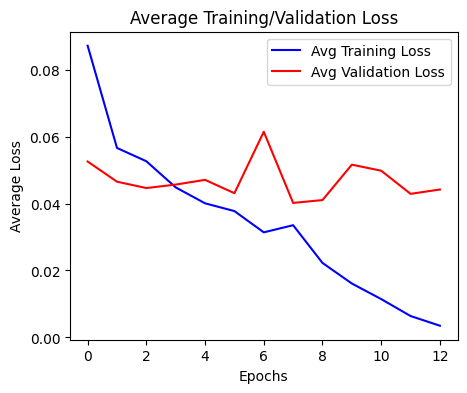

AST Regressor on Valence Dataset
	Spearman Correlation: 0.5261
	MSE: 0.0442
	MAE: 0.1701
	RMSE: 0.2102


In [10]:
set_seed(RANDOM_SEED)
backbone = ASTBackbone(
    fstride=10,                     
    tstride=10,                   
    input_fdim=valence_data[0][0].shape[1],      
    input_tdim=valence_data[0][0].shape[0],     
    imagenet_pretrain=True,      
    model_size='tiny224',          
    feature_size=1    
)

model = train_modular_regressor(
    model_name="cnn_valence",
    backbone=backbone,
    train_loader=valence_train_dl,
    val_loader=valence_val_dl,
    device=DEVICE,
    epochs=EPOCHS,
    lr=LR
)

y_true, y_pred, spear_corrs, pear_corrs = test_model(model, valence_val_dl, DEVICE, regression_flag=True)

print("AST Regressor on Valence Dataset")
get_regression_report(y_pred, y_true, spear_corrs, pear_corrs)

#### Train and Evaluate LSTM Regressor on Energy Dataset

Training started for model model_weights/lstm_energy_best...
Epoch 1/100
	Average Training Loss: 0.09759927067938631 (9.35s)
	Average Validation Loss: 0.055516729530479224(1.10s)
Epoch 2/100
	Average Training Loss: 0.06107352224005535 (9.30s)
	Average Validation Loss: 0.052994602758969576(1.09s)
Epoch 3/100
	Average Training Loss: 0.054445129876906896 (9.54s)
	Average Validation Loss: 0.051679252846432586(1.11s)
Epoch 4/100
	Average Training Loss: 0.0511613776660071 (9.38s)
	Average Validation Loss: 0.045868919763181894(1.11s)
Epoch 5/100
	Average Training Loss: 0.05037205292950425 (9.26s)
	Average Validation Loss: 0.04400032964934196(1.13s)
Epoch 6/100
	Average Training Loss: 0.04726648967779052 (9.38s)
	Average Validation Loss: 0.05197605184678521(1.15s)
Epoch 7/100
	Average Training Loss: 0.046132661740139 (9.31s)
	Average Validation Loss: 0.05081879520522697(1.13s)
Epoch 8/100
	Average Training Loss: 0.04754404384906577 (9.32s)
	Average Validation Loss: 0.04417607663864536(1.15s)
E

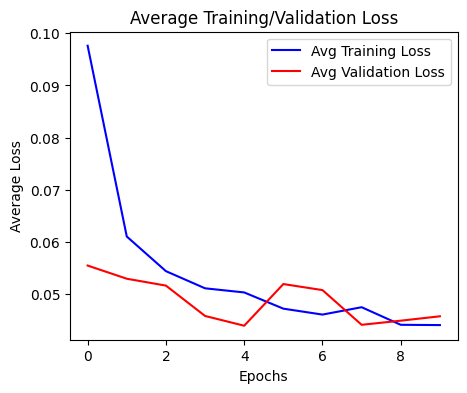

LSTM Regressor on Energy Dataset
	Spearman Correlation: 0.4532
	MSE: 0.0458
	MAE: 0.1690
	RMSE: 0.2140


In [13]:
set_seed(RANDOM_SEED)
backbone = LSTMBackbone(energy_data.feat_dim, rnn_size=64, num_layers=2, bidirectional=True)

model = train_modular_regressor(
    model_name="lstm_energy",
    backbone=backbone,
    train_loader=energy_train_dl,
    val_loader=energy_val_dl,
    device=DEVICE,
    epochs=EPOCHS,
    lr=LR
)

y_true, y_pred, spear_corrs, pear_corrs = test_model(model, energy_val_dl, DEVICE, regression_flag=True)

print("LSTM Regressor on Energy Dataset")
get_regression_report(y_pred, y_true, spear_corrs, pear_corrs)

#### Train and Evaluate CNN Regressor on Energy Dataset

Training started for model model_weights/cnn_energy_best...
Epoch 1/100
	Average Training Loss: 325.1248718581896 (8.14s)
	Average Validation Loss: 2.135332030909402(0.57s)
Epoch 2/100
	Average Training Loss: 1.7828754526851451 (8.10s)
	Average Validation Loss: 1.395279301064355(0.57s)
Epoch 3/100
	Average Training Loss: 0.8203358686141735 (8.11s)
	Average Validation Loss: 0.4915592260658741(0.58s)
Epoch 4/100
	Average Training Loss: 0.47199622736172336 (8.11s)
	Average Validation Loss: 0.28076816563095364(0.57s)
Epoch 5/100
	Average Training Loss: 0.38257931789333843 (8.12s)
	Average Validation Loss: 0.2358192146888801(0.57s)
Epoch 6/100
	Average Training Loss: 0.28736361693096374 (8.12s)
	Average Validation Loss: 0.21480957099369594(0.57s)
Epoch 7/100
	Average Training Loss: 0.4121421177962185 (8.11s)
	Average Validation Loss: 0.5186710017068046(0.57s)
Epoch 8/100
	Average Training Loss: 0.3460550664932327 (8.09s)
	Average Validation Loss: 0.30456823403281824(0.57s)
Epoch 9/100
	Aver

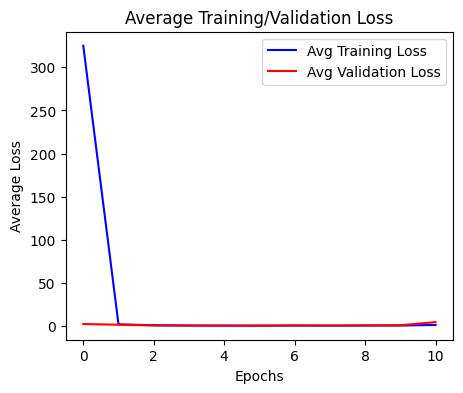

CNN Regressor on Energy Dataset
	Spearman Correlation: -0.0379
	MSE: 4.3558
	MAE: 1.9735
	RMSE: 2.0871


In [14]:
set_seed(RANDOM_SEED)
backbone = CNNBackbone(energy_data[0][0].shape, cnn_in_channels, cnn_filters, cnn_out_feature_size)

model = train_modular_regressor(
    model_name="cnn_energy",
    backbone=backbone,
    train_loader=energy_train_dl,
    val_loader=energy_val_dl,
    device=DEVICE,
    epochs=EPOCHS,
    lr=LR
)

y_true, y_pred, spear_corrs, pear_corrs = test_model(model, energy_val_dl, DEVICE, regression_flag=True)

print("CNN Regressor on Energy Dataset")
get_regression_report(y_pred, y_true, spear_corrs, pear_corrs)

#### Train and Evaluate AST Regressor on Energy Dataset

Training started for model model_weights/cnn_valence_best...
Epoch 1/100
	Average Training Loss: 0.07076756750950508 (29.90s)
	Average Validation Loss: 0.025709580264187286(3.10s)
Epoch 2/100
	Average Training Loss: 0.032697561916079275 (29.94s)
	Average Validation Loss: 0.024715173723442212(3.09s)
Epoch 3/100
	Average Training Loss: 0.02870760061901755 (29.84s)
	Average Validation Loss: 0.024641337388727282(3.09s)
Epoch 4/100
	Average Training Loss: 0.026887972777363208 (31.21s)
	Average Validation Loss: 0.022663599079740897(3.16s)
Epoch 5/100
	Average Training Loss: 0.023791917801661566 (30.07s)
	Average Validation Loss: 0.023180896233368133(3.10s)
Epoch 6/100
	Average Training Loss: 0.025237978159952743 (29.95s)
	Average Validation Loss: 0.024066665875060216(3.12s)
Epoch 7/100
	Average Training Loss: 0.02315981963657634 (30.15s)
	Average Validation Loss: 0.024345100824055926(3.14s)
Epoch 8/100
	Average Training Loss: 0.01921934817517918 (30.15s)
	Average Validation Loss: 0.025104935

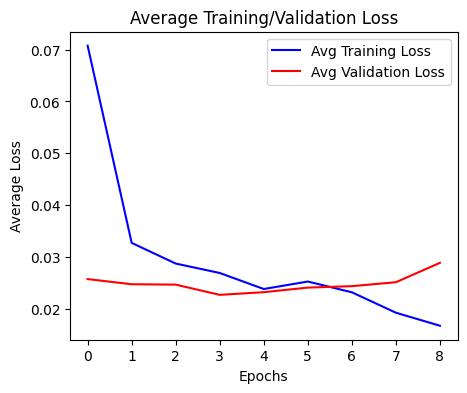

AST Regressor on Energy Dataset
	Spearman Correlation: 0.7285
	MSE: 0.0288
	MAE: 0.1324
	RMSE: 0.1698


In [17]:
set_seed(RANDOM_SEED)
backbone = ASTBackbone(
    fstride=10,                     
    tstride=10,                   
    input_fdim=energy_data[0][0].shape[1],      
    input_tdim=energy_data[0][0].shape[0],     
    imagenet_pretrain=True,      
    model_size='tiny224',          
    feature_size=1    
)

model = train_modular_regressor(
    model_name="cnn_valence",
    backbone=backbone,
    train_loader=energy_train_dl,
    val_loader=energy_val_dl,
    device=DEVICE,
    epochs=EPOCHS,
    lr=LR
)

y_true, y_pred, spear_corrs, pear_corrs = test_model(model, energy_val_dl, DEVICE, regression_flag=True)

print("AST Regressor on Energy Dataset")
get_regression_report(y_pred, y_true, spear_corrs, pear_corrs)

#### Train and Evaluate LSTM Regressor on Danceability Dataset

Free GPU Memory: 98.69%
Training started for model model_weights/lstm_dancability_best...
Epoch 1/100
	Average Training Loss: 0.05071122441605656 (9.39s)
	Average Validation Loss: 0.028326114839208976(1.13s)
Epoch 2/100
	Average Training Loss: 0.02995809693449894 (9.29s)
	Average Validation Loss: 0.02850818101848875(1.13s)
Epoch 3/100
	Average Training Loss: 0.027590129627491786 (9.32s)
	Average Validation Loss: 0.02780707978776523(1.17s)
Epoch 4/100
	Average Training Loss: 0.027767215214749032 (9.41s)
	Average Validation Loss: 0.027748998553891267(1.11s)
Epoch 5/100
	Average Training Loss: 0.026044581468686857 (9.29s)
	Average Validation Loss: 0.02802374812641314(1.12s)
Epoch 6/100
	Average Training Loss: 0.0258206278786261 (9.24s)
	Average Validation Loss: 0.027866240091887966(1.12s)
Epoch 7/100
	Average Training Loss: 0.024845910254470277 (9.27s)
	Average Validation Loss: 0.027978861205545918(1.13s)
Epoch 8/100
	Average Training Loss: 0.025630387869061886 (9.30s)
	Average Validation

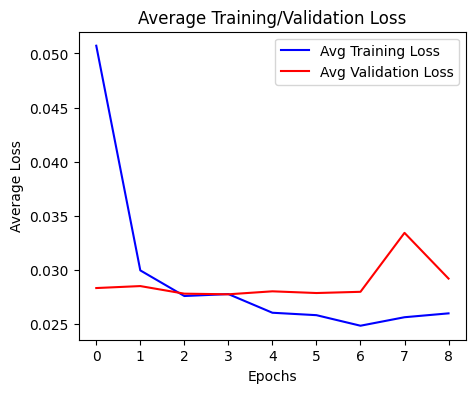

LSTM Regressor on Dancability Dataset
	Spearman Correlation: 0.2645
	MSE: 0.0292
	MAE: 0.1425
	RMSE: 0.1709


In [20]:
set_seed(RANDOM_SEED)
backbone = LSTMBackbone(danceability_data.feat_dim, rnn_size=64, num_layers=2, bidirectional=True)

model = train_modular_regressor(
    model_name="lstm_danceability",
    backbone=backbone,
    train_loader=danceability_train_dl,
    val_loader=danceability_val_dl,
    device=DEVICE,
    epochs=EPOCHS,
    lr=LR
)

y_true, y_pred, spear_corrs, pear_corrs = test_model(model, danceability_val_dl, DEVICE, regression_flag=True)

print("LSTM Regressor on Danceability Dataset")
get_regression_report(y_pred, y_true, spear_corrs, pear_corrs)

#### Train and Evaluate CNN Regressor on Danceability Dataset

Free GPU Memory: 99.32%
Training started for model model_weights/cnn_dancability_best...
Epoch 1/100
	Average Training Loss: 325.8432928452977 (8.15s)
	Average Validation Loss: 1.9745015012366431(0.57s)
Epoch 2/100
	Average Training Loss: 1.8010989606907937 (8.07s)
	Average Validation Loss: 1.7200119782771384(0.57s)
Epoch 3/100
	Average Training Loss: 0.7938481641158593 (8.09s)
	Average Validation Loss: 0.611216077581048(0.57s)
Epoch 4/100
	Average Training Loss: 0.545531262932098 (8.37s)
	Average Validation Loss: 0.2620641269854137(0.58s)
Epoch 5/100
	Average Training Loss: 0.3361430106503246 (8.18s)
	Average Validation Loss: 0.2813820011381592(0.57s)
Epoch 6/100
	Average Training Loss: 0.28323698014152787 (8.21s)
	Average Validation Loss: 0.29346468964857714(0.57s)
Epoch 7/100
	Average Training Loss: 0.34255991210188486 (8.51s)
	Average Validation Loss: 0.37286490947008133(0.69s)
Epoch 8/100
	Average Training Loss: 0.2897026327694148 (8.50s)
	Average Validation Loss: 0.24755243557904

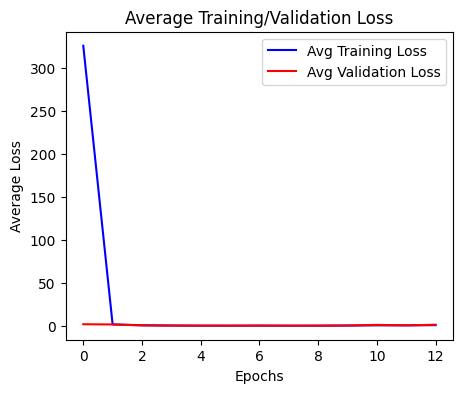

CNN Regressor on Dancability Dataset
	Spearman Correlation: 0.2066
	MSE: 1.4391
	MAE: 0.9783
	RMSE: 1.1996


In [21]:
set_seed(RANDOM_SEED)
backbone = CNNBackbone(danceability_data[0][0].shape, cnn_in_channels, cnn_filters, cnn_out_feature_size)

model = train_modular_regressor(
    model_name="cnn_danceability",
    backbone=backbone,
    train_loader=danceability_train_dl,
    val_loader=danceability_val_dl,
    device=DEVICE,
    epochs=EPOCHS,
    lr=LR
)

y_true, y_pred, spear_corrs, pear_corrs = test_model(model, danceability_val_dl, DEVICE, regression_flag=True)

print("CNN Regressor on Danceability Dataset")
get_regression_report(y_pred, y_true, spear_corrs, pear_corrs)

#### Train and Evaluate AST Regressor on Danceability Dataset

Free GPU Memory: 94.78%
Training started for model model_weights/cnn_valence_best...
Epoch 1/100
	Average Training Loss: 0.04644435062691306 (29.89s)
	Average Validation Loss: 0.02279824247982885(3.10s)
Epoch 2/100
	Average Training Loss: 0.01651147128478418 (30.40s)
	Average Validation Loss: 0.02604329541126(3.18s)
Epoch 3/100
	Average Training Loss: 0.015722801021827732 (29.92s)
	Average Validation Loss: 0.014635046478360891(3.10s)
Epoch 4/100
	Average Training Loss: 0.01614685210943288 (29.80s)
	Average Validation Loss: 0.01565028549105461(3.24s)
Epoch 5/100
	Average Training Loss: 0.014128433756810506 (30.27s)
	Average Validation Loss: 0.014504109575812305(3.10s)
Epoch 6/100
	Average Training Loss: 0.013596046841662147 (30.17s)
	Average Validation Loss: 0.014467842244942273(3.14s)
Epoch 7/100
	Average Training Loss: 0.01139286442750455 (30.39s)
	Average Validation Loss: 0.016168915699901327(3.85s)
Epoch 8/100
	Average Training Loss: 0.012767197584848752 (30.73s)
	Average Validation

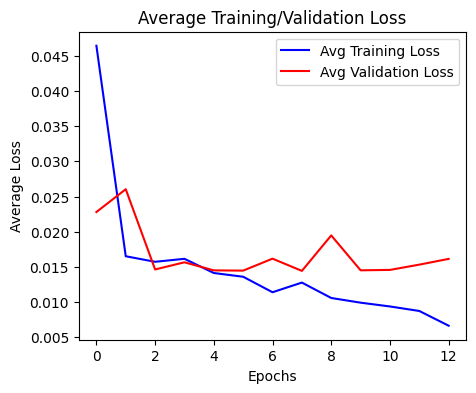

AST Regressor on Dancability Dataset
	Spearman Correlation: 0.6242
	MSE: 0.0161
	MAE: 0.0967
	RMSE: 0.1270


In [22]:
set_seed(RANDOM_SEED)
backbone = ASTBackbone(
    fstride=10,                     
    tstride=10,                   
    input_fdim=danceability_data[0][0].shape[1],      
    input_tdim=danceability_data[0][0].shape[0],     
    imagenet_pretrain=True,      
    model_size='tiny224',          
    feature_size=1    
)

model = train_modular_regressor(
    model_name="cnn_valence",
    backbone=backbone,
    train_loader=danceability_train_dl,
    val_loader=danceability_val_dl,
    device=DEVICE,
    epochs=EPOCHS,
    lr=LR
)

y_true, y_pred, spear_corrs, pear_corrs = test_model(model, danceability_val_dl, DEVICE, regression_flag=True)

print("AST Regressor on Danceability Dataset")
get_regression_report(y_pred, y_true, spear_corrs, pear_corrs)